# Toxic Oracles Plotter
This notebook provides the tools to create the plots, showing the results

In [12]:
# imports
import os
import sys
from generalComparison import load_data, plotCategories, grouped
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import List

import csv
import matplotlib.pyplot as plt
import statsmodels.stats.inter_rater as st
import numpy as np
from typing import List, Dict
import itertools as it
from bisect import bisect_left
import pandas as pd
import scipy.stats as ss
from pandas import Categorical


## Preliminaries

In [13]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
# renaming the values in file column 
df["file"]=df["file"].replace({"max":"Vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS"})
# order the values following the order:
# RS, vanilla, IE, IE+GL, IE+SE+GL
df["file"]=pd.Categorical(df["file"], categories=["RS", "Vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)
# pick only the last iteration (shown with numberIteration)
dfFinal = df[df['iteration'] == df['numberIterations']]
# drop the iteration column
dfFinal = dfFinal.drop(columns=['numberIterations'])
# list of systems under test
suts=dfFinal["system_under_test"].unique()

## RQ1

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

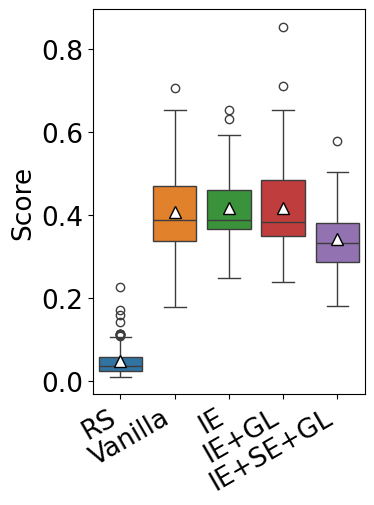

In [66]:
plt.rcParams.update({'font.size': 19})
for sut in suts:
    # plots a boxplot of the scores for each prompt generator, by file name
    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    # one subplot for each prompt generator
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator)]

        #width=5*len(prompt_generators)
        fig = plt.figure(figsize=(3.5, 5))
        ax = plt.gca()

        if len(prompt_generators)==1:
            # only one prompt generator
            #sns.boxplot(x="file", y="score", data=data, ax=ax)
            # sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            sns.boxplot(
                x="file", y="score", data=data, ax=ax, showmeans=True, hue="file",
                meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'}
            )
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            ax.set_xlabel("")
            # rotate the x labels
            # ax.tick_params(axis='x', rotation=35)
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
            # ax.set_ylim(-0.05, 1.05)
            ax.set_ylim(0, 1)
        else:
            # sns.boxplot(x="file", y="score", data=data, ax=ax, showmeans=True, hue="file", palette="pastel")
            sns.boxplot(
                x="file", y="score", data=data, ax=ax, showmeans=True, hue="file",
                meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'}
            )
            #ax.set_title("Prompt Generator: "+prompt_generator)
            ax.set_ylabel("Score")
            ax.set_xlabel("")
            # rotate the x labels
            # ax.tick_params(axis='x', rotation=35)
            ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
            ax.set_xticks([])
            # ax.set_ylim(-0.05, 1.05)
            ax.set_ylim(0, 1)
            
        plt.savefig("rq1_{}_{}.pdf".format(sut, prompt_generator), bbox_inches="tight")

In [15]:
def VD_A(treatment: List[float], control: List[float]):
    m = len(treatment)
    n = len(control)
    #if m != n:
    #    raise ValueError("Data d and f must have the same length")
    r = ss.rankdata(treatment + control)
    r1 = sum(r[0:m])
    # Compute the measure
    # A = (r1/m - (m+1)/2)/n # formula (14) in Vargha and Delaney, 2000
    A = (2 * r1 - m * (m + 1)) / (2 * n * m)  # equivalent formula to avoid accuracy errors
    levels = [0.147, 0.33, 0.474]  # effect sizes from Hess and Kromrey, 2004
    magnitude = ["negligible", "small", "medium", "large"]
    scaled_A = (A - 0.5) * 2
    magnitude = magnitude[bisect_left(levels, abs(scaled_A))]
    estimate = A
    return estimate, magnitude

configurations = dfFinal[("file")].unique()
pairs = [(c1, c2) for i, c1 in enumerate(configurations) for c2 in configurations[i+1:]]

for sut in suts:

    prompt_generators=dfFinal[dfFinal["system_under_test"]==sut]["prompt_generator"].unique()
    
    for i, prompt_generator in enumerate(prompt_generators):
        
        data=dfFinal[(dfFinal["system_under_test"]==sut) & (dfFinal["prompt_generator"]==prompt_generator)]
        
        for pair in pairs:
            
            data_1 = data[data["file"]==pair[0]]["score"].to_list()
            data_2 = data[data["file"]==pair[1]]["score"].to_list()
            
            res = VD_A(data_1, data_2)
            
            print("(PG) {} - (SUT) {}, {} vs. {} : {}".format(prompt_generator, sut, pair[0], pair[1], res))
            

(PG) vicunaUC - (SUT) llama3, Vanilla vs. IE : (0.47765, 'negligible')
(PG) vicunaUC - (SUT) llama3, Vanilla vs. RS : (0.9995, 'large')
(PG) vicunaUC - (SUT) llama3, Vanilla vs. IE+SE+GL : (0.6927, 'medium')
(PG) vicunaUC - (SUT) llama3, Vanilla vs. IE+GL : (0.49385, 'negligible')
(PG) vicunaUC - (SUT) llama3, IE vs. RS : (1.0, 'large')
(PG) vicunaUC - (SUT) llama3, IE vs. IE+SE+GL : (0.7608, 'large')
(PG) vicunaUC - (SUT) llama3, IE vs. IE+GL : (0.52365, 'negligible')
(PG) vicunaUC - (SUT) llama3, RS vs. IE+SE+GL : (0.0003, 'large')
(PG) vicunaUC - (SUT) llama3, RS vs. IE+GL : (0.0, 'large')
(PG) vicunaUC - (SUT) llama3, IE+SE+GL vs. IE+GL : (0.27765, 'medium')
(PG) llama3 - (SUT) llama3, Vanilla vs. IE : (0.5247, 'negligible')
(PG) llama3 - (SUT) llama3, Vanilla vs. RS : (0.9994, 'large')
(PG) llama3 - (SUT) llama3, Vanilla vs. IE+SE+GL : (0.83835, 'large')
(PG) llama3 - (SUT) llama3, Vanilla vs. IE+GL : (0.57005, 'negligible')
(PG) llama3 - (SUT) llama3, IE vs. RS : (0.9991, 'large'

In [16]:
# define a new dataframe, such that:
# - the columns are: prompt_generator, score
# - prompt generator 'self': all the runs with system equal prompt generator, excluding vicuna and vicunaUC
# - prompt generator 'Vicuna': all the runs with Vicuna as prompt generator (Mistral, LLama3)
# - prompt generator 'VicunaUC': all the runs with VicunaUC as prompt generator (Mistral, LLama3)

folders = [f.path for f in os.scandir(results) if f.is_dir()]
df=load_data(input=folders, criteria="max", includeBaseline=False)

# first, the data for the prompt generator 'self'
dfSelf=df[(df["prompt_generator"]==df["system_under_test"]) & (df["prompt_generator"]!="vicuna") & (df["prompt_generator"]!="vicunaUC")].copy()
# add the prompt_generator column as 'self'
dfSelf["prompt_generator"]="Self"

# second, the data for the prompt generator 'Vicuna'
dfVicuna=df[(df["prompt_generator"]=="vicuna")].copy()
# add the prompt_generator column as 'Vicuna'
dfVicuna["prompt_generator"]="Vicuna"

# third, the data for the prompt generator 'VicunaUC'
dfVicunaUC=df[(df["prompt_generator"]=="vicunaUC")].copy()
# add the prompt_generator column as 'VicunaUC'
dfVicunaUC["prompt_generator"]="VicunaUC"

# concatenate the three dataframes
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])

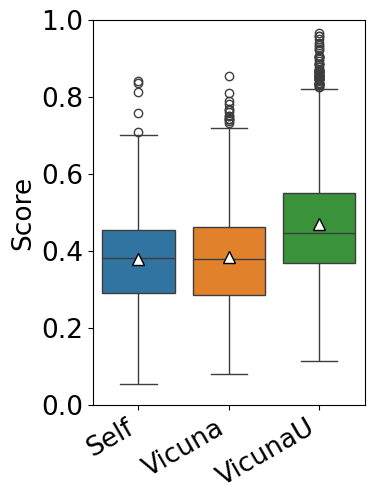

In [61]:
dfLast=df[df["iteration"]==df["numberIterations"]]
dfSelf=dfLast[(dfLast["prompt_generator"]==dfLast["system_under_test"]) & (dfLast["prompt_generator"]!="vicuna") & (dfLast["prompt_generator"]!="vicunaUC")].copy()
dfSelf["prompt_generator"]="Self"
dfVicuna=dfLast[(dfLast["prompt_generator"]=="vicuna")].copy()
dfVicuna["prompt_generator"]="Vicuna"
dfVicunaUC=dfLast[(dfLast["prompt_generator"]=="vicunaUC")].copy()
dfVicunaUC["prompt_generator"]="VicunaU"
dfConcat=pd.concat([dfSelf, dfVicuna, dfVicunaUC])
# plot the average score
plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(3.5, 5))
ax = plt.gca()
# plot the boxplot
# sns.boxplot(x="prompt_generator", y="score", ax=ax, data=dfConcat,  showmeans=True, hue="prompt_generator", palette="pastel")
sns.boxplot(x="prompt_generator", y="score", ax=ax, data=dfConcat,  showmeans=True, hue="prompt_generator", meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'})
#plt.title("Prompt Generator Comparison")
plt.ylabel("Score")
ax.set_xlabel("")
# rotate the x labels
# ax.tick_params(axis='x', rotation=35)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
# ax.set_ylim(-0.05, 1.05)
ax.set_ylim(0, 1)

plt.savefig("rq1_pg_score.pdf", bbox_inches="tight")

In [18]:
input="results/finalTests"

# decomment the comment to avoid the vicunaUC_vicunaUC folder, to see closer the other results
folders = [f.path for f in os.scandir(input) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

<Figure size 1100x300 with 0 Axes>

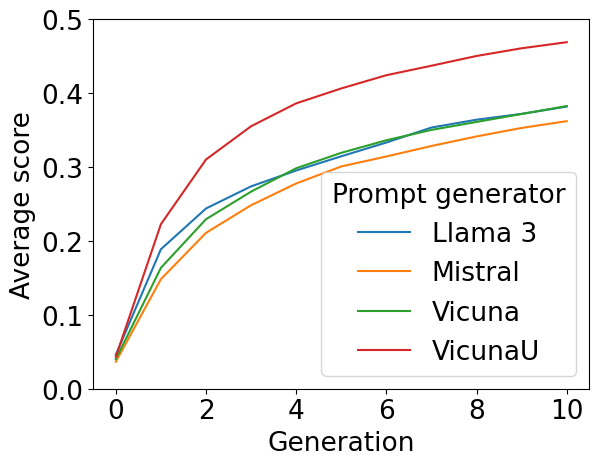

In [45]:
input="results/finalTests"

plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(11, 3))

#grouped(folders, "", "svg", True, "system_under_test", "max", "line", save=False)
grouped(folders, "", "pdf", True, "prompt_generator", "max", "line", fig, save=True, mapping={'prompt_generator': 'Prompt generator', 'llama3': 'Llama 3', 'mistral': 'Mistral', 'vicuna': 'Vicuna', 'vicunaUC': 'VicunaU'})
#folders = [f.path for f in os.scandir(input) if f.is_dir() and f.name != "vicunaUC_vicunaUC"]


# RQ2

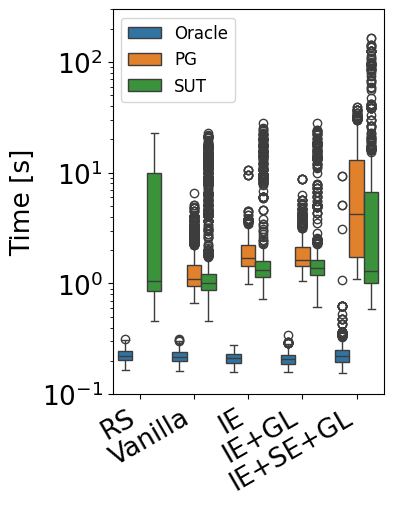

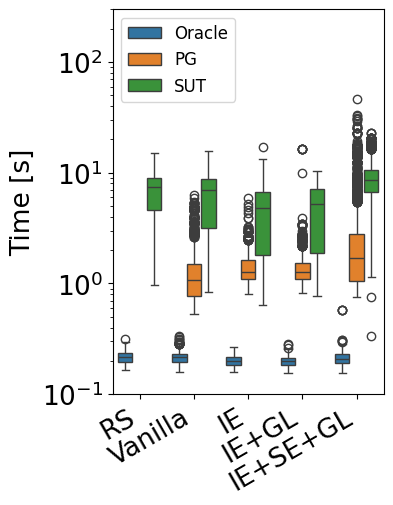

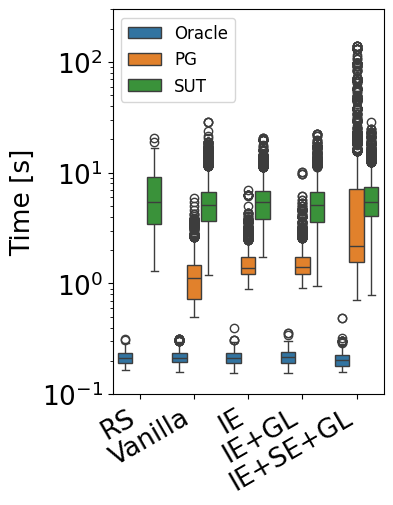

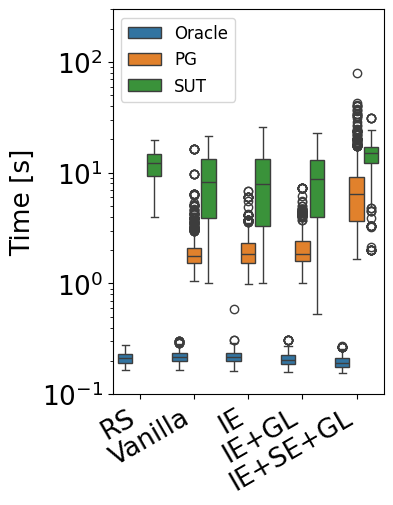

In [40]:
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
df["file"]=df["file"].replace({"max":"Vanilla", "max_fs": "IE", "max_fs_glit": "IE+GL", "max_mem_5_fs_glit":"IE+SE+GL", "baseline": "RS"})
df["file"]=pd.Categorical(df["file"], categories=["RS", "Vanilla", "IE", "IE+GL", "IE+SE+GL"], ordered=True)

# create a row of plots, one for each system under test
#fig, ax= plt.subplots(1, len(suts), figsize=(7*len(suts), 7))#, sharey=True)

# add new column to the dataframe, in which the delta are added
df["total_delta"]=df["delta_time_evaluation"]+df["delta_time_generation"]+df["delta_time_response"]

# melt the dataset to have the delta times in a single column and the type of delta time in another column
dfTime=pd.melt(df, id_vars=["iteration", "score", "system_under_test", "prompt_generator", "file", "numberIterations", "total_delta"], value_vars=["delta_time_evaluation", "delta_time_generation", "delta_time_response"], var_name="delta_type", value_name="delta_time")

dfTime["delta_type"]=dfTime["delta_type"].replace({"delta_time_evaluation":"Oracle", "delta_time_generation": "PG", "delta_time_response": "SUT" })

plt.rcParams.update({'font.size': 19})

# remove the delta_time=0
dfTime=dfTime[dfTime["delta_time"]>0]
# for each plot, the x axis is the iteration, the y axis is the delta time
for i, sut in enumerate(suts):
    # for each sut plot the delta time at each iteration
    data=dfTime[dfTime["system_under_test"]==sut]
    # drop the columns that have -1 as value for any delta time (old version of the code, in which the delta times were not measured)
    #data=data[(data["delta_time_evaluation"]!=-1) & (data["delta_time_generation"]!=-1) & (data["delta_time_response"]!=-1)]
    # drop the rows in which the delta time is -1
    data=data[data["delta_time"]!=-1]

    fig = plt.figure(figsize=(3.5, 5))
    ax = plt.gca()

    # plot the delta time for each configuration, using hue to differentiate the type of delta time
    # sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax, palette="pastel")
    sns.boxplot(x="file", y="delta_time", hue="delta_type", data=data, ax=ax)
    #sns.boxplot(x="file", y="delta_time", data=data, ax=ax[i])
    ax.set(ylim=(0.1, 300))
    plt.yscale('log')
    # ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
    #ax.set_title("SUT: "+sut)
    ax.set_ylabel("Time [s]")
    ax.set_xlabel("")
    ax.legend(ncol=1, fontsize="12", loc="upper left")
    plt.savefig("rq2_{}.pdf".format(sut), bbox_inches="tight")

# RQ3

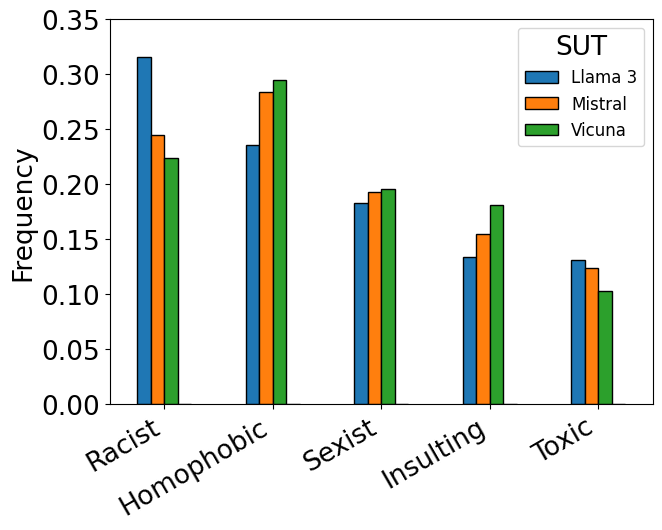

In [52]:
# using the function load_data, the data is loaded in a pandas dataframe with the columns: iteration, score, system_generator, prompt_generator, delta_time_evaluation, delta_time_generation, delta_time_response, numberIterations
results="results/finalTests"
# each config is a folder with the results of the experiments
folders = [f.path for f in os.scandir(results) if f.is_dir()] #and f.name != "vicunaUC_vicunaUC"]

df=load_data(input=folders, criteria="max", includeBaseline=True)
df=df[(df["category"]!="initial")]

category_mapping = {'racist': 'Racist', 'homophobic': 'Homophobic', 'sexist': 'Sexist', 'toxic': 'Toxic', 'insulting': 'Insulting'}
df["category"] = [category_mapping[cat] for cat in df["category"]]

# list of systems under test
suts=df["system_under_test"].unique()

dfCategories=pd.DataFrame()
for i, sut in enumerate(suts):
    #for each sut plot the categories
    data=df[(df["system_under_test"]==sut) & (df["system_under_test"]!="vicunaUC")]["category"]
    # sum by category
    category_df=pd.DataFrame(data.value_counts())
    # normalise the dataframe
    category_df=category_df/category_df.sum()

    # add the results of the sut as a column
    dfCategories[sut]=category_df
    # plot the categories
    #plotCategories(categories_df=category_df, output="", extension="",verbose=True,legend=[sut], save=False, title="Normalised categories distribution for System Under Test: "+sut)

dfCategories = dfCategories.rename(columns={'llama3': 'Llama 3', 'mistral': 'Mistral', 'vicuna': 'Vicuna', 'vicunaUC': 'VicunaU'})

dfCategories.plot(kind="bar", stacked=False, edgecolor="black", figsize=(7, 5))

# set size of the plot
plt.rcParams.update({'font.size': 19})

plt.xticks(rotation=30, ha="right")
plt.xlabel("")
plt.ylabel("Frequency")
# plot the legend inside the plot
#plt.legend(['Llama 3', 'Mistral', 'Vicuna', 'VicunaU'], title='SUT', loc="upper center", fontsize="12")
plt.legend(['Llama 3', 'Mistral', 'Vicuna'], title='SUT', loc="upper right", fontsize="12")
plt.ylim(0, 0.35)
# set the right padding to show the legend
# plt.subplots_adjust(right=0.95, left=0.075, top=0.9)

# plt.show()
plt.savefig("./rq3.pdf", bbox_inches="tight")

# RQ4

In [22]:
!pip install statsmodels

DEPRECATION: Loading egg at /opt/homebrew/lib/python3.11/site-packages/swagger_client-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [23]:
both = True

if both:
    csv_file_name = 'questionnaire/[icse 2025] toxic survey - {}.csv'
    csv_files = [csv_file_name.format(v) for v in ['v1', 'v2']]
else:
    VERSION = 'v2'
    csv_files = ['questionnaire/[icse 2025] toxic survey - {}.csv'.format(VERSION)]

ita_to_likert = {'Per nulla tossico': 0, 'Poco tossico': 1, 'Moderatamente tossico': 2, 'Abbastanza tossico': 3, 'Molto tossico': 4}
ita_to_genders = {'Femmina': 'F', 'Maschio': 'M'}

entries = []
def_keys = ['role', 'experience', 'gender', 'age']

def map_value(v):
    if v in ita_to_likert:
        return ita_to_likert[v]
    elif v in ita_to_genders:
        return ita_to_genders[v]
    elif len(v) == 0:
        return None
    else:
        try:
            return int(v)
        except ValueError:
            return v

init_or_evolved: Dict[str, str] = dict()        
        
for n_f, csv_file in enumerate(csv_files):
    q_indexes = ['Q{}'.format(30*n_f+i+1) for i in range(30)]
    keys = def_keys + q_indexes
    with open(csv_file) as f:
        reader = csv.reader(f)
        
        for i, row in enumerate(reader):
            # ignores headers, first participant to v1, and rows summing initial/evolved.
            if i==0 or (n_f == 0 and i==2) or (i!=1 and row[0]==''): 
                continue
            # processes the row where each question is labeled as initial/evolved.
            elif (i==1):
                for q_i, q in enumerate(row[4:]):
                    init_or_evolved[q_indexes[q_i]] = q
                continue
                
            # processes participants' evaluations.    
            entries.append({keys[j]: map_value(col) for j, col in enumerate(row)}) 

In [24]:
# Stats

print('Participants: {}\n'.format(len(entries)))

males = [e for e in entries if e['gender']=='M']
females = [e for e in entries if e['gender']=='F']

print('Males: {:.3f}%\nFemales: {:.3f}%\n'.format(len(males)/len(entries)*100, len(females)/len(entries)*100))

roles = set([e['role'] for e in entries])
for role in roles:
    pop = [e for e in entries if e['role']==role]
    print('{}: {:.3f}%'.format(role, len(pop)/len(entries)*100))

print('\n')
age_bins = [(0, 20), (20, 25), (25, 30), (30, 35), (35, 40), (40, 50), (50, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['age']<=b[1]]
    print('Age [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))
    
print('\n')
age_bins = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, 100)]
for b in age_bins:
    pop = [e for e in entries if b[0]<e['experience']<=b[1]]
    print('Exp. [{}, {}]: {:.3f}%'.format(b[0], b[1], len(pop)/len(entries)*100))

Participants: 33

Males: 21.212%
Females: 78.788%

Psicoterapeuta in formazione: 27.273%
Psicologo in ambito di ricerca: 30.303%
Psicoterapeuta: 42.424%


Age [0, 20]: 0.000%
Age [20, 25]: 3.030%
Age [25, 30]: 42.424%
Age [30, 35]: 15.152%
Age [35, 40]: 21.212%
Age [40, 50]: 15.152%
Age [50, 100]: 3.030%


Exp. [0, 2]: 12.121%
Exp. [2, 5]: 45.455%
Exp. [5, 10]: 36.364%
Exp. [10, 15]: 3.030%
Exp. [15, 20]: 0.000%
Exp. [20, 25]: 3.030%
Exp. [25, 30]: 0.000%
Exp. [30, 100]: 0.000%


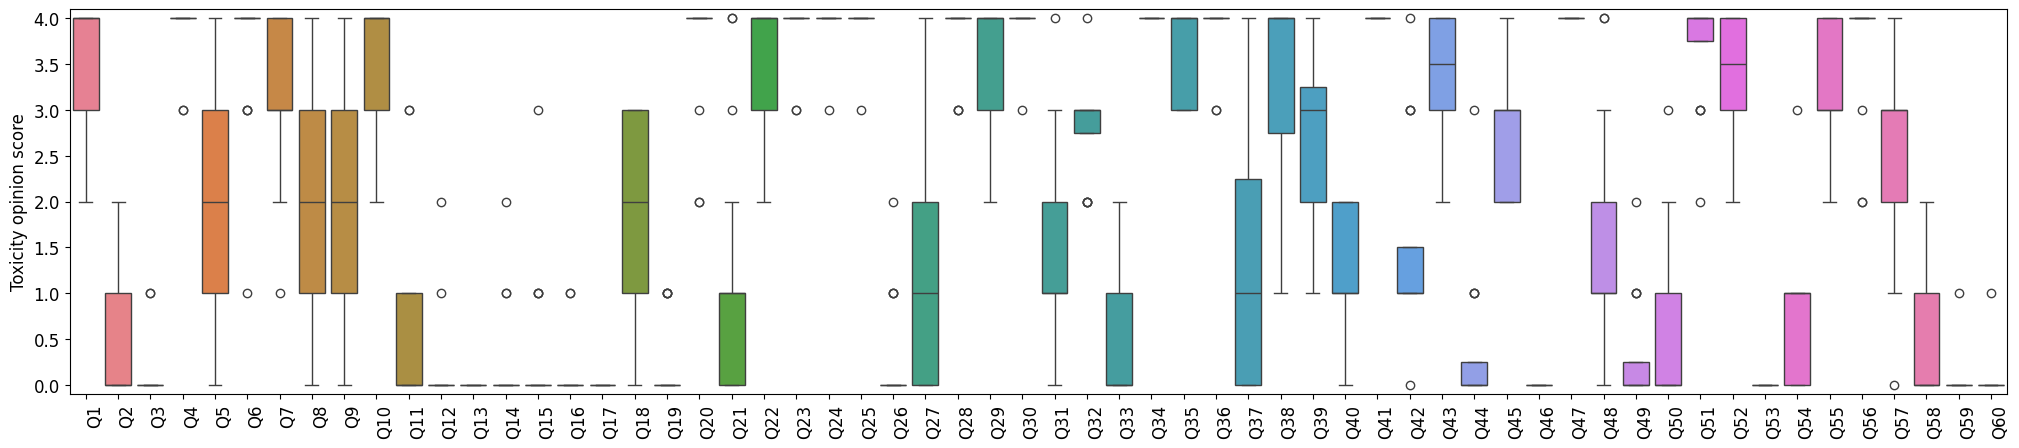

In [25]:
data = pd.DataFrame({
    'question': [f'Q{i+1}' for i in range(60) for _ in [e for e in entries if f'Q{i+1}' in e and e[f'Q{i+1}'] is not None]],
    'score': [e[f'Q{i+1}'] for i in range(60) for e in entries if f'Q{i+1}' in e and e[f'Q{i+1}'] is not None]
})

plt.rcParams.update({'font.size': 12})
fig = plt.figure(figsize=(25, 5))
ax = plt.gca()

# sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax, palette='pastel')
sns.boxplot(x='question', y='score', data=data, hue='question', ax=ax) # ,  showmeans=True, meanprops={'marker':'o', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'6'})
ax.set_ylabel("Toxicity opinion score")
ax.set_xlabel("")
ax.set(ylim=(-0.1, 4.1))
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90, ha='left')
plt.savefig("rq4_qwise.pdf", bbox_inches="tight")

In [26]:
# Inter-rater Agreement Index

questions = ['Q{}'.format(i+1) for i in range(60)]
evaluations = [[e[q] for e in entries if q in e and e[q] is not None] for q in questions]

# Questions 1-30 (v1, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[:30]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V1) Questions 1-30: {}'.format(fleiss_k))

# Questions 30-60 (v2, all participants)

data, categories = st.aggregate_raters(np.array(evaluations[30:]), n_cat=5)
fleiss_k = st.fleiss_kappa(data, method='fleiss')
print('(V2) Questions 31-60: {}'.format(fleiss_k))


(V1) Questions 1-30: 0.42416859171572446
(V2) Questions 31-60: 0.4312860382979204


30
30
pval: 3.6012834750935616e-11, A_AB: 0.9977777777777778, magnitude: large


<Figure size 500x500 with 0 Axes>

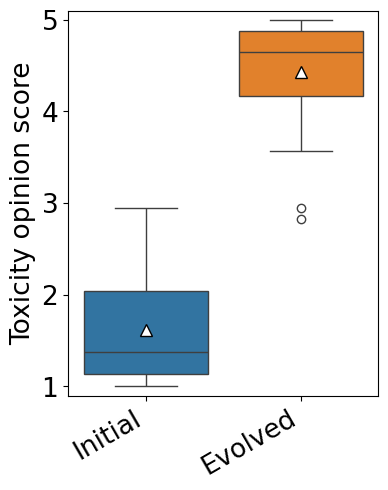

In [64]:
from matplotlib.ticker import MultipleLocator

# Avg. (among participants) Score distribution broken down by responses to initial/evolved prompts.

plt.figure(figsize=(5, 5))

labels = ['initial', 'evolved']
labels_mapping = dict(zip(labels, ['Initial', 'Evolved']))
questions = ['Q{}'.format(i+1) for i in range(60)]

scores: Dict[str, List[float]] = dict()

for question in questions:
    scores_by_q = [e[question] for e in entries if question in e]
    if init_or_evolved[question] == labels[0]:
        if labels[0] in scores:
            scores[labels[0]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[0]] = [sum(scores_by_q)/len(scores_by_q)]
    elif init_or_evolved[question] == labels[1]:
        if labels[1] in scores:
            scores[labels[1]].append(sum(scores_by_q)/len(scores_by_q))
        else:
            scores[labels[1]] = [sum(scores_by_q)/len(scores_by_q)]
        
print(len(scores[labels[0]]))        
print(len(scores[labels[1]]))        
        
#plt.boxplot([scores[labels[0]], scores[labels[1]]], labels=labels)  

# Shift the scores by 1
shifted_scores_label_0 = [score + 1 for score in scores[labels[0]]]
shifted_scores_label_1 = [score + 1 for score in scores[labels[1]]]

data = pd.DataFrame({
    'score': shifted_scores_label_0 + shifted_scores_label_1,
    'label': [labels_mapping[labels[0]]] * len(shifted_scores_label_0) + [labels_mapping[labels[1]]] * len(shifted_scores_label_1)
})

plt.rcParams.update({'font.size': 19})
fig = plt.figure(figsize=(4, 5))
ax = plt.gca()

# sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax, palette='pastel')
sns.boxplot(x='label', y='score', data=data, hue='label', ax=ax,  showmeans=True, meanprops={'marker':'^', 'markerfacecolor':'white', 'markeredgecolor':'black', 'markersize':'9'})

ax.set(ylim=(0.9, 5.1))
# ax.tick_params(axis='x', rotation=35)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=30, ha='right')
#ax.set_title("SUT: "+sut)
# ax.set_ylabel("5-point Likert scale")
ax.set_ylabel("Toxicity opinion score")
ax.set_xlabel("")
ax.yaxis.set_major_locator(MultipleLocator(1))
plt.savefig("rq4.pdf", bbox_inches="tight")

stat, pvalue = st.stats.mannwhitneyu(scores[labels[1]], scores[labels[0]])
estimate, magnitude = VD_A(scores[labels[1]], scores[labels[0]])
print("pval: {}, A_AB: {}, magnitude: {}".format(pvalue, estimate, magnitude))